# 0. Datasets Variable Descriptions

## ⚡ Energy Dataset Variables

The energy dataset contains hourly electricity generation values by source, load information, and market price.

---

##### 🔋 Generation Variables (Energy Produced by Each Source)

**`generation_biomass`**  
Electricity produced from biomass combustion. Renewable but dispatchable, with moderate cost.

**`generation_fossil_brown_coal_lignite`**  
Electricity generated from lignite-fired plants. Cheap but polluting baseload source.

**`generation_fossil_coal-derived_gas`**  
Electricity produced from gases derived from coal processing. Less common and relatively high-cost.

**`generation_fossil_gas`**  
Generation from natural gas plants. Often the marginal price setter in European electricity markets.

**`generation_fossil_hard_coal`**  
Electricity from hard coal plants. Used mainly as baseload or mid-merit generation.

**`generation_fossil_oil`**  
Electricity produced from oil-based power plants. Very expensive; typically dispatched only during peak hours.

**`generation_fossil_oil_shale`**  
Electricity produced from oil shale combustion. Rare and high-cost.

**`generation_fossil_peat`**  
Electricity produced from peat combustion. Similar to coal but with lower energy density.

**`generation_geothermal`**  
Electricity generated from geothermal heat sources. Stable, renewable, and typically low marginal cost.

---

##### 💧 Hydro Generation Variables

**`generation_hydro_pumped_storage_aggregated`**
Electricity generated by pumped-storage hydro plants during discharge.

**`generation_hydro_pumped_storage_consumption`**  
Electricity consumed during pumping operations. Represents energy used to store water.

**`generation_hydro_run-of-river_and_poundage`**  
Electricity produced from run-of-river hydro plants, highly dependent on river flow.

**`generation_hydro_water_reservoir`**  
Generation from hydroelectric reservoirs. Used strategically during high-price periods.

---

##### ☢️ Other Generation Sources

**`generation_marine`**  
Electricity produced from marine energy sources (waves/tides). Rare and experimental.

**`generation_nuclear`**  
Stable baseload electricity from nuclear plants. Very low marginal cost.

**`generation_other`**  
Electricity generated from unspecified sources.

**`generation_other_renewable`**  
Renewable energy not classified into other specific categories.

**`generation_solar`**  
Electricity generated from solar photovoltaic systems. Highly dependent on sunlight and time of day.

**`generation_waste`**  
Electricity produced from waste incineration.

**`generation_wind_offshore`**  
Electricity generated by offshore wind farms. Typically more stable winds and higher output.

**`generation_wind_onshore`**  
Electricity produced from onshore wind turbines. More variable due to local wind patterns.

---

##### 🌬 Forecast Variable

**`forecast_wind_offshore_eday_ahead`**  
Day-ahead forecast of offshore wind generation. Forecast accuracy influences expected market prices.

---

##### 🔌 Load / Demand Variable

**`total_load_actual`**  
Measured hourly electricity demand. A primary driver of electricity prices — higher load usually increases price.

---

##### 💶 Price Variable (Target)

**`price_day_ahead`**  
The day-ahead hourly electricity price. This is the **target variable** for prediction in the project.


## 🌦 Weather Dataset Variables

The weather dataset provides hourly meteorological conditions that influence electricity demand and renewable generation.

---

##### 🌡 Temperature

**`temperature`**  
Air temperature. Strongly influences heating and cooling demand, and therefore total electricity consumption.

---

##### 🧭 Atmospheric Pressure

**`pressure`**  
Atmospheric pressure. Useful for identifying weather systems that affect wind availability.

---

##### 💧 Humidity

**`humidity`**  
Relative humidity of the air. Provides atmospheric context but has indirect influence on electricity systems.

---

##### 🌬 Wind

**`wind_speed`**  
Wind speed at the measurement location. Directly affects wind power production levels and therefore supply conditions in the electricity market.

# 1. Data understanding and preparation

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

energy = pd.read_csv("Dataset/energy_dataset.csv", parse_dates=["time"], index_col="time")
weather = pd.read_csv("Dataset/weather.csv", parse_dates=["time"], index_col="time")

energy.head(), weather.head()

(                           generation_biomass  \
 time                                            
 2015-01-01 00:00:00+01:00               447.0   
 2015-01-01 01:00:00+01:00               449.0   
 2015-01-01 02:00:00+01:00               448.0   
 2015-01-01 03:00:00+01:00               438.0   
 2015-01-01 04:00:00+01:00               428.0   
 
                            generation_fossil_brown_coal_lignite  \
 time                                                              
 2015-01-01 00:00:00+01:00                                 329.0   
 2015-01-01 01:00:00+01:00                                 328.0   
 2015-01-01 02:00:00+01:00                                 323.0   
 2015-01-01 03:00:00+01:00                                 254.0   
 2015-01-01 04:00:00+01:00                                 187.0   
 
                            generation_fossil_coal-derived_gas  \
 time                                                            
 2015-01-01 00:00:00+01:00            

### Checking the datasets shape

In [49]:
print("Energy shape:", energy.shape)
print("Weather shape:", weather.shape)

energy.info()
weather.info()

Energy shape: (35064, 24)
Weather shape: (35064, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal_lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-

### Checking the datasets statistics

In [50]:
energy.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,0.0,35028.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,NaN,28696.939905,49.874341
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,NaN,4574.987950,14.618900
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,18041.000000,2.060000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,NaN,24807.750000,41.490000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,NaN,28901.000000,50.520000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,NaN,32192.000000,60.530000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,NaN,41015.000000,101.990000


In [51]:
weather.describe()

,temperature,pressure,humidity,wind_speed
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,289.706862,1017.297872,68.033025,2.442944
std,7.251796,6.363845,14.814871,1.276415
min,272.006000,999.500000,22.600000,0.000000
25%,284.098877,1013.475000,56.750000,1.400000
50%,289.036200,1017.000000,69.600000,2.200000
75%,295.100500,1021.000000,80.000000,3.200000
max,309.048000,1035.500000,100.000000,8.500000


### Checking for null/missing values

In [52]:
energy.isna().sum()

generation_biomass                                19
generation_fossil_brown_coal_lignite              18
generation_fossil_coal-derived_gas                18
generation_fossil_gas                             18
generation_fossil_hard_coal                       18
generation_fossil_oil                             19
generation_fossil_oil_shale                       18
generation_fossil_peat                            18
generation_geothermal                             18
generation_hydro_pumped_storage_aggregated     35064
generation_hydro_pumped_storage_consumption       19
generation_hydro_run-of-river_and_poundage        19
generation_hydro_water_reservoir                  18
generation_marine                                 19
generation_nuclear                                17
generation_other                                  18
generation_other_renewable                        18
generation_solar                                  18
generation_waste                              

In [53]:
weather.isna().sum()

temperature    0
pressure       0
humidity       0
wind_speed     0
dtype: int64

### Checking for duplicated indexes

In [54]:
print("Duplicated timestamps in energy:", energy.index.duplicated().sum())
print("Duplicated timestamps in weather:", weather.index.duplicated().sum())

Duplicated timestamps in energy: 0
Duplicated timestamps in weather: 0


### Verify temporal alignment

In [55]:
print("Energy:", energy.index.min(), " -> ", energy.index.max())
print("Weather:", weather.index.min(), " -> ", weather.index.max())

Energy: 2015-01-01 00:00:00+01:00  ->  2018-12-31 23:00:00+01:00
Weather: 2015-01-01 00:00:00+01:00  ->  2018-12-31 23:00:00+01:00


### Joining the datasets by time index

In [56]:
df = energy.join(weather, how="inner")
df.shape

(35064, 28)

In [57]:
df.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_marine,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead,temperature,pressure,humidity,wind_speed
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,0.0,35028.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,NaN,28696.939905,49.874341,289.706862,1017.297872,68.033025,2.442944
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,NaN,4574.987950,14.618900,7.251796,6.363845,14.814871,1.276415
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,18041.000000,2.060000,272.006000,999.500000,22.600000,0.000000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,NaN,24807.750000,41.490000,284.098877,1013.475000,56.750000,1.400000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,NaN,28901.000000,50.520000,289.036200,1017.000000,69.600000,2.200000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,NaN,32192.000000,60.530000,295.100500,1021.000000,80.000000,3.200000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,NaN,41015.000000,101.990000,309.048000,1035.500000,100.000000,8.500000


### Setting target variable (price)

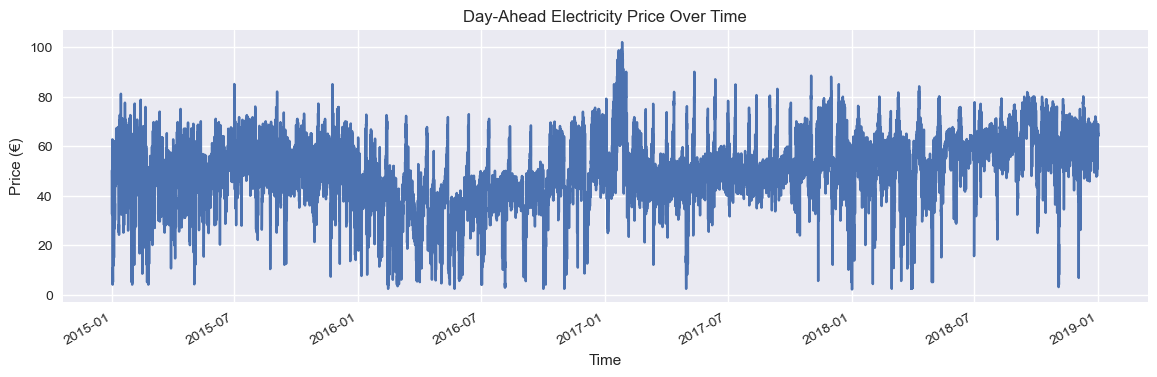

In [58]:
target = "price_day_ahead"

df[target].plot(figsize=(14,4))
plt.title("Day-Ahead Electricity Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price (€)")
plt.show()

### Target variable correlations

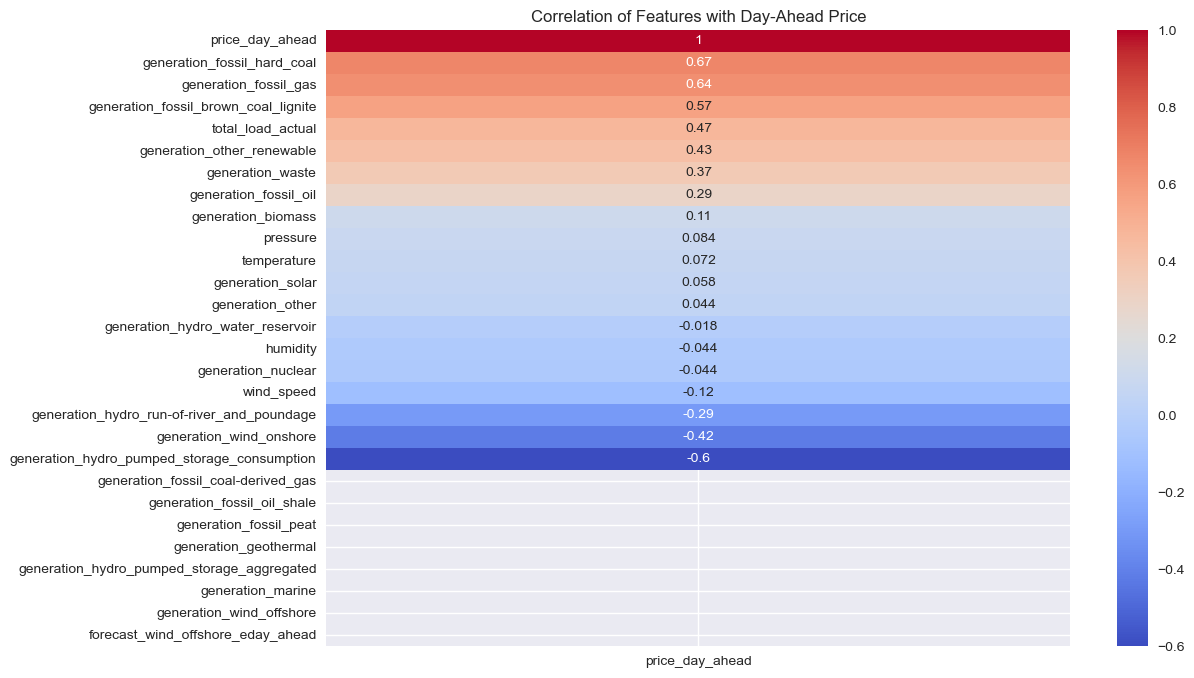

In [59]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False), 
            cmap="coolwarm", annot=True)
plt.title("Correlation of Features with Day-Ahead Price")
plt.show()

In [60]:
df.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False).head(20)

,price_day_ahead
price_day_ahead,1.000000
generation_fossil_hard_coal,0.671596
generation_fossil_gas,0.640895
generation_fossil_brown_coal_lignite,0.567905
total_load_actual,0.473869
generation_other_renewable,0.428078
generation_waste,0.368036
generation_fossil_oil,0.292793
generation_biomass,0.108945
pressure,0.084098


# 2. Data pre-processing